In [ ]:
# automatically reload the package when it is modified
%load_ext autoreload
%autoreload 2

In [ ]:
from mtr.config import cfg, cfg_from_list, cfg_from_yaml_file, log_config_to_file
from mtr.datasets.waymo.waymo_dataset_bc import WaymoDatasetBC as WaymoDataset
# from mtr.datasets.waymo.waymo_dataset import WaymoDataset

from tools.mtr_env import BatchMTREnv
from tools.mtr_inference import MTRInference
from tools.mtr_lightning import MTR_Lightning
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch.distributions import MultivariateNormal, MixtureSameFamily, Categorical, Independent

cfg = cfg_from_yaml_file('tools/cfgs/waymo/bc+10_percent_data.yaml', cfg)
dataset = WaymoDataset(cfg.DATA_CONFIG, training=False)
env = BatchMTREnv(1, dataset)

model = MTR_Lightning(cfg)
model = model.load_from_checkpoint('output/bc_full_residual/epoch=49-step=152600.ckpt')
_ = model.cuda()


# Test with dataset

In [ ]:
output_mean = model.model.motion_decoder.output_mean
output_std = model.model.motion_decoder.output_std

In [ ]:
data = dataset[5]
data_batch = dataset.collate_batch([data])

In [ ]:
# model.train()
model.eval()
with torch.no_grad():
    loss, _, output = model.model(data_batch, True)
    center_gt_raw = output['input_dict']['center_gt'][..., :3]
    center_gt = output['input_dict']['center_gt'][...,None, :3].cuda()
    center_gt = (center_gt - output_mean) / output_std
    pred_scores = output['pred_scores']
    pred_ctrls = output['pred_ctrls']

In [ ]:

i=0
print(pred_ctrls[i,:, :3])
print(center_gt[i])

In [ ]:
# best_idx = (pred_ctrls[...,:3] - center_gt).norm(dim=-1, p=1).argmin(dim=-1)
# print(best_idx)
# pred_ctrls_best = pred_ctrls[torch.arange(pred_ctrls.shape[0]), best_idx]
mode = model.model.motion_decoder.build_mode_distribution(pred_ctrls[...,:])
log_p = mode.log_prob(center_gt)
print(log_p[0])
# log_p.argmin(dim=-1)
# cls_loss = torch.functional.F.cross_entropy(input=pred_scores, target= best_idx, reduction='none')
# print(cls_loss)

In [ ]:
_, mode, gmm = model.model.motion_decoder.build_gmm_distribution(pred_ctrls, pred_scores)
log_p = -gmm.log_prob(center_gt.squeeze(1))
log_p

In [ ]:
mode, mix, gmm, sample = model.sample(data_batch)
print(sample)
print(center_gt_raw)

# Test in simulation

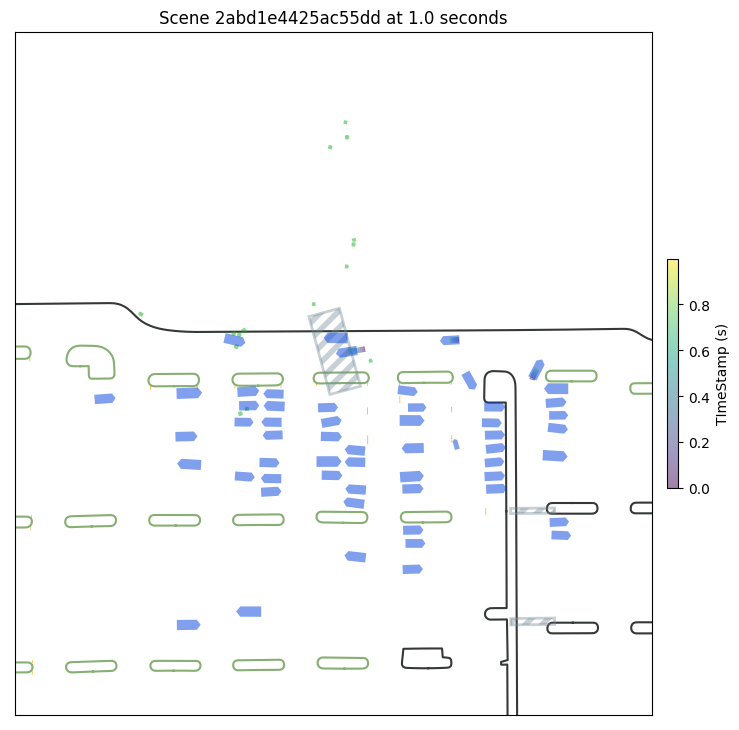

In [200]:
env.reset()
env.visualize()
index = env.envs_list[0].index
current_time_index = env.envs_list[0].current_time_index 
data_batch_sim = env.batch_scene_data
data_dataset = dataset.collate_batch([dataset.getdata(index, current_time_index)])

In [206]:

gt = data_dataset['input_dict']['center_gt'][..., :3].cpu().numpy()
action_sim = model.sample(data_batch_sim)[-1]
print(gt - action_sim)
action_dataset = model.sample(data_dataset)[-1]
print(gt - action_dataset)
# print(data_dataset['input_dict']['center_gt'][..., :3]) 
# _ = env.step(action)


[[ 0.04483813  0.00838081  0.00367923]
 [ 0.05540773 -0.00779366 -0.00188829]
 [ 0.01024161 -0.00480498  0.00231077]]
[[ 0.03788489  0.00854354  0.01620695]
 [ 0.05964229 -0.00744232 -0.0017344 ]
 [-0.00026138 -0.00458279 -0.00325499]]


In [202]:
data_dataset['input_dict'].keys()


dict_keys(['scenario_id', 'obj_trajs', 'obj_trajs_mask', 'track_index_to_predict', 'obj_trajs_pos', 'obj_trajs_last_pos', 'obj_types', 'obj_ids', 'center_objects_world', 'center_objects_id', 'center_objects_type', 'center_gt', 'center_gt_mask', 'center_gt_trajs_src', 'map_polylines', 'map_polylines_mask', 'map_polylines_center', 't_sample'])

In [205]:
t = 0
id = 'obj_trajs'
i = 0
j = 1
t = 10
d = 0
val_dataset = data_dataset['input_dict'][id]
val_sim = data_batch_sim['input_dict'][id]

print(val_dataset.shape)
print(val_sim.shape)
# print(val_dataset - val_sim)
print(((val_dataset - val_sim).abs()>1e-1).any())

torch.Size([3, 74, 11, 29])
torch.Size([3, 74, 11, 29])
tensor(False)
